In [3]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMolConformers, AlignMol
from rdkit.Chem.Draw import rdMolDraw2D
from conf_ensemble_library import ConfEnsembleLibrary
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from molconfviewer import MolConfViewer
from litschnet import LitSchNet
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
from ConfScorer import ConfAnalyzer
from sklearn.metrics import r2_score
from energy_calculator import XtbEnergyCalculator
from rdkit.Chem.rdMolTransforms import SetDihedralDeg, GetDihedralDeg
from collections import namedtuple, defaultdict

AttributeError: 'NoneType' object has no attribute 'origin'

In [ ]:
def get_model() :
    split = 'random'
    iteration = 2
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    model.eval()
    return model

In [ ]:
def save_2d_depiction(mol, path, atom_indices=False) :
    d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
    if atom_indices :
        d2d.drawOptions().addAtomIndices=True
    mol_copy = copy.deepcopy(mol)
    mol_copy.RemoveAllConformers()
    d2d.DrawMolecule(mol_copy)
    d2d.FinishDrawing()
    d2d.WriteDrawingText(path) 

In [ ]:
def get_most_similar_mol_in_train(test_mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(test_mol, 3, useChirality=True)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim_idx = np.argmax(sims)
    print('Tanimoto similarity: ', np.max(sims))
    sim_smiles = train_smiles[max_sim_idx]

    sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
    return sim_ce.mol

In [5]:
split = 'random'
iteration = 2
with open(os.path.join('data/', f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

In [6]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 3, useChirality=True) for mol in train_mols]

In [7]:
mcv = MolConfViewer()
mf = MoleculeFeaturizer()
ca = ConfAnalyzer()
xtb_calculator = XtbEnergyCalculator()

In [8]:
# look at the bioactive conformation identification performance of highly flexible molecules

mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = f'results/{split}_split_{iteration}_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [9]:
# rot bond 5 active = 1 (sans max training sim) was good

In [52]:
rot_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 3 :
        rot_smiles.append(smiles)

In [53]:
active_smiles = []
for smiles in rot_smiles :
    mol_r = mol_results[smiles]
    if 'normalized_first_bioactive_like_rank' in mol_r :
        if (mol_r['normalized_first_bioactive_like_rank']['model'] == 0) and (mol_r['n_actives'] < 10) and (mol_r['n_generated'] == 100) and (mol_r['max_sim_to_training'] < 0.5):
            active_smiles.append(smiles)

In [54]:
active_smiles

['CN1C(=[NH2+])N[C@@]2(c3ccc(-c4ccc(F)c(C#N)c4)s3)CN(c3ccccc3)C[C@H]2C1=O']

In [55]:
smiles = active_smiles[0]
cel = ConfEnsembleLibrary()
cel.load_metadata()
ce = cel.load_ensemble_from_smiles(smiles, 'merged')
mol = ce.mol
AlignMolConformers(mol)
print(mol_results[smiles]['normalized_first_bioactive_like_rank'])

{'model': 0.0, 'ccdc': 0.05, 'energy': 0.05, 'random': 0.16}


(0.0, 3.6174629747867586)

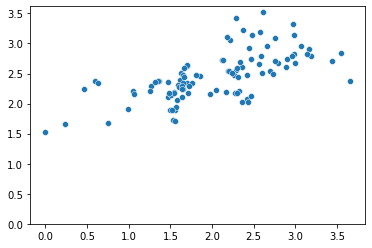

In [56]:
sns.scatterplot(x=conf_results[smiles]['targets'], y=conf_results[smiles]['preds'])
plt.ylim(0)

In [57]:
mcv.view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [58]:
save_2d_depiction(mol, 'mol_for_pres.png', atom_indices=True)

In [59]:
gen_mol = copy.deepcopy(mol)
gen_mol.RemoveConformer(100)
bio_mol = copy.deepcopy(mol)
bio_mol.RemoveAllConformers()
bio_mol.AddConformer(mol.GetConformer(100), assignId=True)
AlignMol(gen_mol, bio_mol)

1.6141849018579104

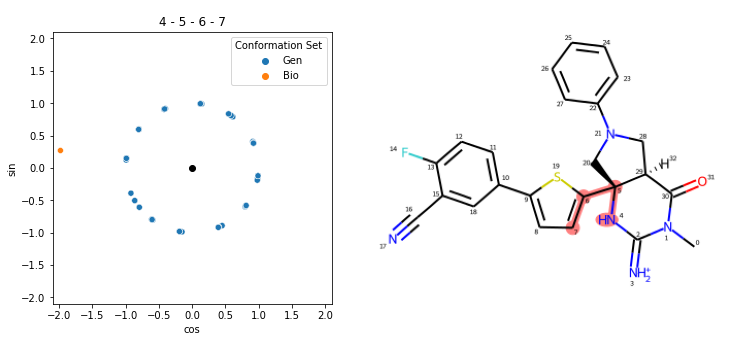

<Figure size 432x288 with 0 Axes>

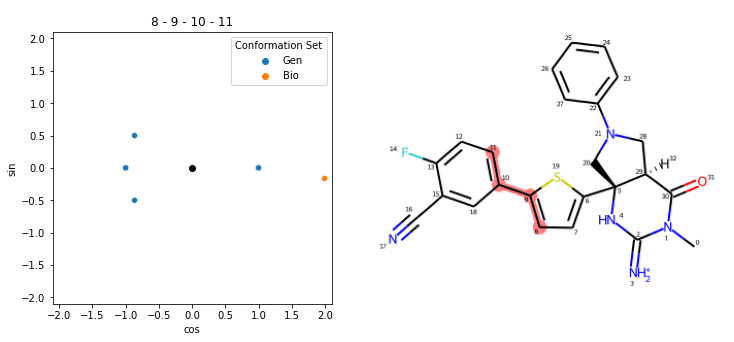

<Figure size 432x288 with 0 Axes>

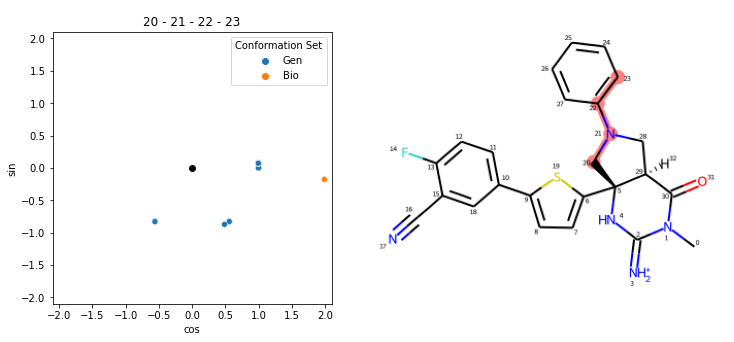

<Figure size 432x288 with 0 Axes>

In [60]:
ConfAnalyzer().plot_rotatable_histograms_ref_vs_gen({'Gen' : gen_mol, 'Bio': bio_mol})

In [61]:
with Chem.SDWriter('gen_mols.sdf') as sdwriter :
    for i in range(100) :
        sdwriter.write(gen_mol, confId=i)

with Chem.SDWriter('gen_mol.sdf') as sdwriter :
    sdwriter.write(gen_mol)

with Chem.SDWriter('bio_mol.sdf') as sdwriter :
    sdwriter.write(bio_mol)

In [62]:
pmp = PDBBindMetadataProcessor()
table = pmp.get_master_dataframe(remove_peptide_ligands=False)

In [63]:
test_mol = ce.mol
pdb_ids = [conf.GetProp('PDB_ID') for conf in test_mol.GetConformers()]
table[table['PDB code'].isin(pdb_ids)]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
12115,4h3j,1.60,2012,7.05,Ki=90nM //,4h1e.pdf,(10W),"[nM, =, 90]",=,90.0,nM,2012,P56817,BETA-SECRETASE 1,True


In [64]:
save_2d_depiction(test_mol, 'generated_ranking_results/test_mol.png')

AlignMolConformers(test_mol)
mcv.view(test_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [65]:
sdwriter = Chem.SDWriter('generated_ranking_results/mol.sdf')
for conf in test_mol.GetConformers() :
    sdwriter.write(test_mol, confId=conf.GetId())
sdwriter.close()

In [66]:
train_mol = get_most_similar_mol_in_train(test_mol, train_fps)
pdb_ids = [conf.GetProp('PDB_ID') for conf in train_mol.GetConformers()]
table[table['PDB code'].isin(pdb_ids)]

Tanimoto similarity:  0.40119760479041916


,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
17253,4h1e,1.90,2012,8.52,Ki=3nM //,4h1e.pdf,(10J),"[nM, =, 3]",=,3.0,nM,2012,P56817,BETA-SECRETASE 1,True


In [67]:
save_2d_depiction(train_mol, 'train_mol_for_pres.png', atom_indices=True)

In [68]:
gen_mol = copy.deepcopy(train_mol)
gen_mol.RemoveConformer(100)
bio_mol = copy.deepcopy(train_mol)
bio_mol.RemoveAllConformers()
bio_mol.AddConformer(train_mol.GetConformer(100), assignId=True)
AlignMol(gen_mol, bio_mol)

3.0613968528983575

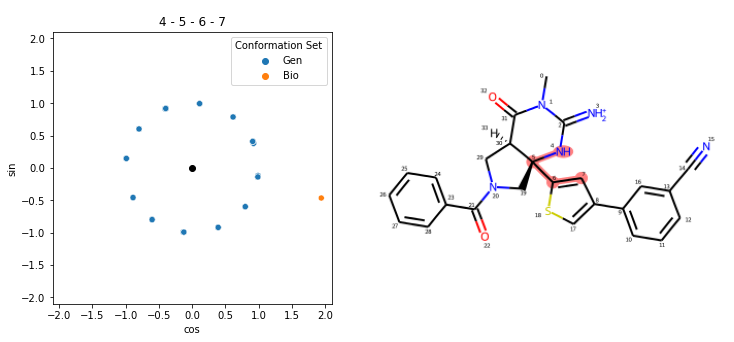

<Figure size 432x288 with 0 Axes>

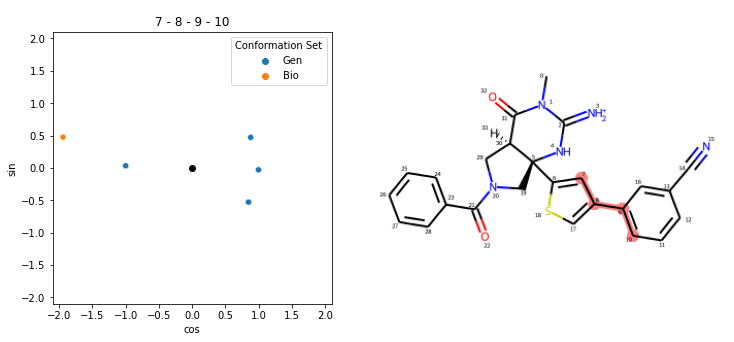

<Figure size 432x288 with 0 Axes>

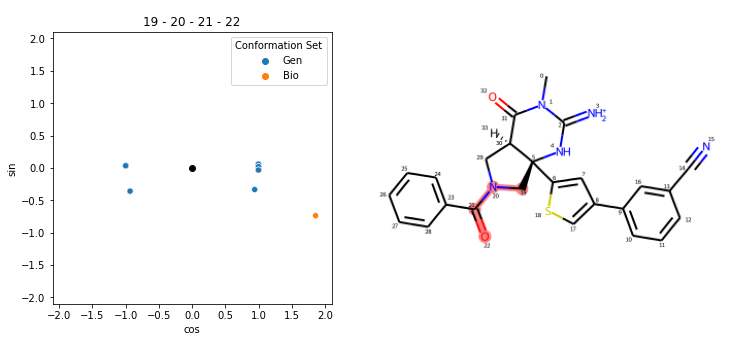

<Figure size 432x288 with 0 Axes>

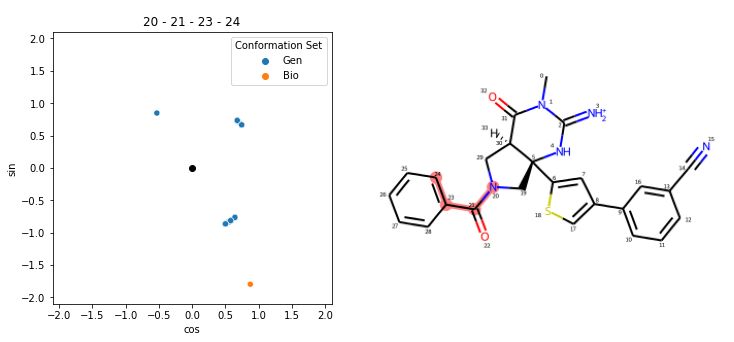

<Figure size 432x288 with 0 Axes>

In [69]:
ConfAnalyzer().plot_rotatable_histograms_ref_vs_gen({'Gen' : gen_mol, 'Bio': bio_mol})

In [70]:
mcv.view(train_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [71]:
mcs = rdFMCS.FindMCS([test_mol, train_mol])
core = Chem.MolFromSmarts(mcs.smartsString)

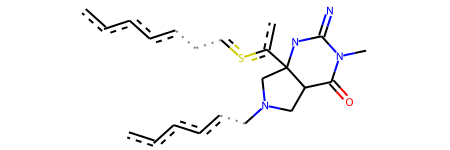

In [72]:
core

In [73]:
def mol_3d_to_2d(mol) :
    copy_mol = copy.deepcopy(mol)
    copy_mol.RemoveAllConformers()
    return copy_mol

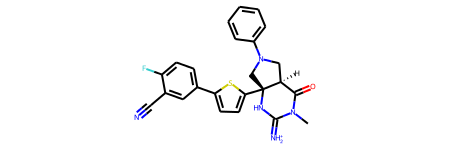

In [74]:
copy_1 = mol_3d_to_2d(ce.mol)
copy_1

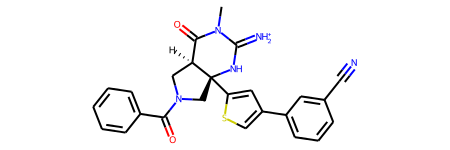

In [75]:
copy_2 = mol_3d_to_2d(train_mol)
copy_2

In [76]:
query_match = copy_1.GetSubstructMatch(core)
template_match = copy_2.GetSubstructMatch(core)
AllChem.Compute2DCoords(copy_1)
AllChem.Compute2DCoords(copy_2)
rms = AlignMol(copy_1, copy_2, atomMap=list(zip(query_match,template_match)))
save_2d_depiction(copy_1, 'generated_ranking_results/mol1.png')
save_2d_depiction(copy_2, 'generated_ranking_results/mol2.png')

In [77]:
model = get_model()
model.eval()
import torch
with torch.no_grad() :
    model.show_atomic_contributions(test_mol, save_dir='test_contributions/')
    model.show_atomic_contributions(train_mol, save_dir='train_contributions/')

In [78]:
mol_featurizer = MoleculeFeaturizer()

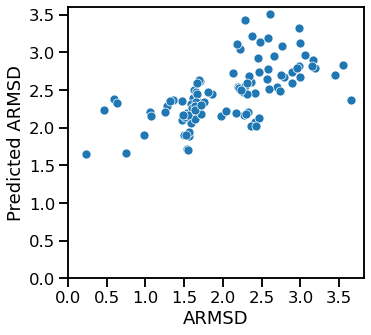

In [117]:
gen_mol = copy.deepcopy(test_mol)
gen_mol.RemoveConformer(100)
with torch.no_grad() :
    test_data_list = mol_featurizer.featurize_mol(gen_mol)
    test_batch = Batch.from_data_list(test_data_list)
    test_rmsds = mol_featurizer.get_bioactive_rmsds(test_mol)
    test_preds = model(test_batch).reshape(-1)
    
with sns.plotting_context('talk') :
    df = pd.DataFrame({'ARMSD' : test_rmsds[:100], 'Predicted ARMSD' : test_preds})
    plt.figure(figsize=(5.5,5))
    sns.scatterplot(data=df, x='ARMSD', y='Predicted ARMSD')
    plt.ylim(0)
    plt.xlim(0)
    #plt.show()
    plt.tight_layout()
    plt.savefig('generated_ranking_results/regression.png', dpi=300)

In [80]:
test_preds.argsort()

tensor([100,  38,  21,  22,  20,  37,   1,  76,   5,  75,  23,  80,   4,   3,
          6,  18,  79,  19,  40,  84,   8,  86,  85,  68,  90,  47,  41,  89,
         57,  83,  64,   9,  94,  36,  82,  93,   2,  96,  10,  92,  81,  11,
         95,  39,  78,  35,  28,  77,  91,   0,  45,  74,  14,  24,  32,  52,
         73,  62,   7,  55,  67,  25,  51,  13,  27,  98,  88,  48,  12,  16,
         87,  49,  30,  33,  97,  53,  56,  34,  99,  54,  50,  31,  71,  66,
         72,  65,  63,  17,  15,  60,  46,  42,  69,  44,  70,  43,  61,  26,
         29,  58,  59])

In [99]:
test_rmsds[21]

tensor(0.7464)

In [100]:
test_preds[21]

tensor(1.6688)

In [95]:
test_rmsds[59]

tensor(2.6094)

In [96]:
test_preds[59]

tensor(3.5150)

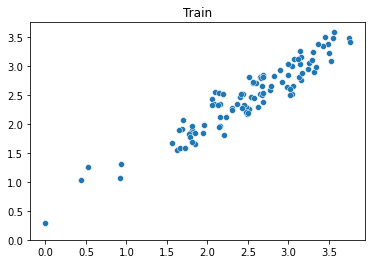

In [81]:
with torch.no_grad() :
    train_data_list = mol_featurizer.featurize_mol(train_mol)
    train_batch = Batch.from_data_list(train_data_list)
    train_rmsds = mol_featurizer.get_bioactive_rmsds(train_mol)
    train_preds = model(train_batch).reshape(-1)
    sns.scatterplot(x=train_rmsds, y=train_preds)
    plt.ylim(0)
    plt.title('Train')
    plt.show()

In [83]:
train_preds.argsort()

tensor([100,  46,  80,  44,  78,   8,  10,  81,  51,  58,  79,  32,  83,  30,
         88,  23,  20,  42,  16,  35,  69,  26,  75,  86,  40,  63,  39,   4,
         47,  45,  56,   6,  37,  55,  13,  21,  84,  43,  49,  41,  72,  24,
         64,  38,  95,  76,  94,  60,  96,  70,  99,   0,  54,  18,  65,  89,
         36,  73,  90,  33,   2,  92,  82,  12,  15,  52,  50,   1,  61,  27,
         67,  48,   3,  57,  14,  29,  59,  17,  74,  62,  53,   5,   9,  34,
         68,  28,  93,   7,  91,  11,  31,  98,  97,  77,  87,  25,  71,  19,
         66,  85,  22])

In [84]:
ac_test = model.get_atomic_contributions(test_batch).detach().numpy()
grouped_ac_test = ac_test.reshape(test_mol.GetNumConformers(), test_mol.GetNumAtoms())

In [85]:
ac_train = model.get_atomic_contributions(train_batch).detach().numpy()
grouped_ac_train = ac_train.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [86]:
match_test = list(test_mol.GetSubstructMatch(core))
match_train = list(train_mol.GetSubstructMatch(core))
test_to_train = dict(zip(match_test, match_train))

In [92]:
save_2d_depiction(test_mol, path='test_mol_for_pres.png')

<AxesSubplot:>

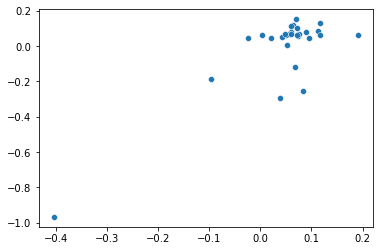

In [87]:
sns.scatterplot(x=grouped_ac_test[100][match_test], y=grouped_ac_train[100][match_train])

<AxesSubplot:>

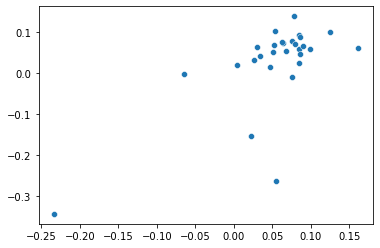

In [88]:
sns.scatterplot(x=grouped_ac_test[38][match_test], y=grouped_ac_train[46][match_train])

<AxesSubplot:>

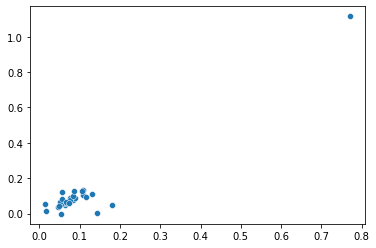

In [89]:
sns.scatterplot(x=grouped_ac_test[59][match_test], y=grouped_ac_train[22][match_train])

In [ ]:
# take test bio
# make one authorized torsion change in the trainMCS
# 

In [73]:
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg

In [74]:
GetDihedralDeg(test_mol.GetConformer(100), 6, 8, 9, 10)

1.0089404113867837

In [87]:
diffs = np.zeros((101,101))
for i in range(101) :
    conf1 = test_mol.GetConformer(i)
    degs1 = np.array([GetDihedralDeg(conf1, *rot_bond) for rot_bond in sub_rot_bonds_test])
    for j in range(i + 1, 101) :
        conf2 = test_mol.GetConformer(j)
        degs2 = np.array([GetDihedralDeg(conf2, *rot_bond) for rot_bond in sub_rot_bonds_test])
        diffs[i, j] = diffs[j, i] = np.sum(np.abs(degs1 - degs2))

In [88]:
diffs.argsort()

array([[  0,  20,  40, ...,  96,  85,  24],
       [  1,   8,   5, ...,  49,  65,  25],
       [  2,  41,   9, ...,  22,  64,  81],
       ...,
       [ 98,  33,  91, ...,  17,  80,  76],
       [ 99,  35,  93, ...,  52,  83,  18],
       [100,  75,  82, ...,  66,  97,  96]])

In [101]:
test_preds[100]

tensor(0.3864)

In [90]:
diffs[100, 75]

132.75980114679294

In [96]:
i = 100
conf1 = test_mol.GetConformer(i)
degs1 = np.array([GetDihedralDeg(conf1, *rot_bond) for rot_bond in sub_rot_bonds_test])
j = 100
conf2 = train_mol.GetConformer(j)
degs2 = np.array([GetDihedralDeg(conf2, *rot_bond) for rot_bond in sub_rot_bonds_train])

In [97]:
degs1 - degs2

array([  3.41826405, -11.51423335,   0.14312103,   1.39994666])

In [107]:
i = 100
conf1 = test_mol.GetConformer(i)
degs1 = np.array([GetDihedralDeg(conf1, *rot_bond) for rot_bond in sub_rot_bonds_test])
j = 75
conf2 = test_mol.GetConformer(j)
degs2 = np.array([GetDihedralDeg(conf2, *rot_bond) for rot_bond in sub_rot_bonds_test])

In [108]:
test_preds[j]

tensor(1.3066)

In [109]:
test_rmsds[j]

tensor(1.3045)

In [110]:
degs1 - degs2

array([ 10.57479349, -13.34840033, -98.92379511,  -9.91281221])

In [111]:
test_rmsds.argsort()

tensor([100,  52,  98,  46,  55,  89,  90,  48,  43,  38,  91,  82,  83,  87,
         84,  68,  71,  70,  36,  88,  53,  85,  72,  33,  69,  39,  86,  40,
         75,   9,  15,  14,  16,  13,  51,  18,  24,  79,  50,  47,  99,  54,
          4,  78,  22,  29,  37,  10,  74,  77,  49,  11,  93,  45,  41,  44,
         92,  28,  81,  94,   8,   0,  23,  17,  35,  32,  12,   2,  63,  60,
         73,   7,  42,  26,   1,  95,  76,  80,   6,  67,  64,   5,  19,  96,
         97,   3,  31,  27,  20,  21,  25,  56,  58,  30,  57,  59,  62,  61,
         34,  66,  65])

In [112]:
i = 100
conf1 = test_mol.GetConformer(i)
degs1 = np.array([GetDihedralDeg(conf1, *rot_bond) for rot_bond in sub_rot_bonds_test])
j = 65
conf2 = test_mol.GetConformer(j)
degs2 = np.array([GetDihedralDeg(conf2, *rot_bond) for rot_bond in sub_rot_bonds_test])

In [113]:
test_preds[j]

tensor(1.7034)

In [114]:
test_rmsds[j]

tensor(2.0633)

In [115]:
degs1 - degs2

array([  85.57403526,  -13.34902733, -140.66762141,  -67.40022223])

In [91]:
mcv.view(test_mol)
mcv.view(test_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [48]:
import importlib
import mol_drawer
importlib.reload(mol_drawer)
MolDrawer = mol_drawer.MolDrawer

In [50]:
def rot_bond_in_sub(rot_bond) :
    for i in rot_bond :
        if not i in match_test :
            return False
    return True

In [51]:
rot_bonds_test = ConfAnalyzer().get_rotatable_bonds_atom_idx(mol=test_mol)

In [52]:
sub_rot_bonds_test = []
for rot_bond in rot_bonds_test :
    if rot_bond_in_sub(rot_bond) :
        sub_rot_bonds_test.append(rot_bond)

In [53]:
sub_rot_bonds_test

[(0, 1, 3, 4), (1, 3, 4, 5), (6, 8, 9, 10), (8, 9, 11, 12)]

In [54]:
sub_rot_bonds_train = [tuple([test_to_train[i] for i in rot_bond]) for rot_bond in sub_rot_bonds_test]

In [55]:
sub_rot_bonds_train

[(6, 5, 4, 3), (5, 4, 3, 2), (1, 15, 16, 17), (15, 16, 18, 19)]

In [56]:
diffs = np.zeros((100,100))
for i in range(100) :
    conf_test = test_mol.GetConformer(i)
    degs_test = np.array([GetDihedralDeg(conf_test, *rot_bond) for rot_bond in sub_rot_bonds_test])
    for j in range(100) :
        conf_train = train_mol.GetConformer(j)
        degs_train = np.array([GetDihedralDeg(conf_train, *rot_bond) for rot_bond in sub_rot_bonds_train])
        diffs[i, j] = np.sum(np.abs(degs_test - degs_train))

In [57]:
diffs.flatten()

array([257.20019007, 334.11367692, 437.0464002 , ..., 262.29949835,
       491.1022416 , 671.10520728])

In [58]:
diffs.argmin()

3633

In [59]:
diffs[36, 33]

6.9765718787170625

In [60]:
AlignMol(test_mol, train_mol, 36, 33, atomMap=list(zip(match_test, match_train)))

0.24682878753489051

In [69]:
test_rmsds[36]

tensor(1.2279)

In [70]:
train_rmsds[33]

tensor(2.0590)

In [61]:
mcv.view(test_mol)
mcv.view(train_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [168]:
MolDrawer().plot_values_for_mol(mol=test_mol, values=diff, suffix=f'diff_{i1}_{i2}', save_dir='atomic_contributions_diff')

NameError: name 'diff' is not defined

In [123]:
diff_train = grouped_ac_train[14] - grouped_ac_train[74]
diff_test = grouped_ac_test[19] - grouped_ac_test[98]

<AxesSubplot:>

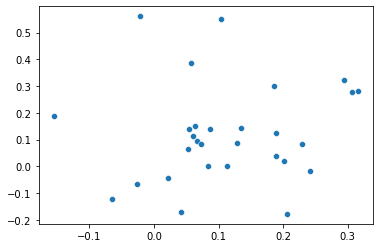

In [124]:
sns.scatterplot(x=diff_test[match_test], y=diff_train[match_train])

In [127]:
rms = AlignMol(test_mol, train_mol, 100, 100, atomMap=list(zip(match_test, match_train)))

In [128]:
rms

0.3466349351999201

In [71]:
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
copy_test = copy.deepcopy(test_mol)

In [80]:
GetDihedralDeg(copy_test.GetConformer(100), 4,5,6,7)

179.5648228481927

In [81]:
SetDihedralDeg(copy_test.GetConformer(100), 4,5,6,7, 60)

In [82]:
mcv.view(copy_test)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [83]:
data_list = mol_featurizer.featurize_mol(copy_test)
batch = Batch.from_data_list(data_list)

In [84]:
preds.argsort()

tensor([100,  98,  40,  18,   9,  55,  63,  89,  31,  49,  65,   8,  96,  27,
          6,  30,  45,   2,  94,  28,  86,  70,  35,  56,  99,  60,  36,  90,
         46,  15,  48,  17,  69,  10,  32,  51,  53,  85,  34,  59,  66,  68,
         41,  44,   1,  62,  87,  23,  97,  71,  93,  74,  81,  39,  26,  29,
         33,  43,  42,  82,  91,  64,  20,  67,  58,  75,  25,   3,  13,   7,
         78,  77,  50,  61,  92,  83,  73,  54,  72,  12,  16,   0,  37,  47,
         84,   5,  95,   4,  22,  76,  88,  57,  21,  80,  24,  14,  79,  52,
         38,  11,  19])

In [85]:
ac_test = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac_test_copy = ac_test.reshape(test_mol.GetNumConformers(), test_mol.GetNumAtoms())

In [86]:
grouped_ac_test_copy

array([[ 0.06421293, -0.01018251, -0.0220217 , ...,  0.09383167,
         0.03837889,  0.02431765],
       [ 0.12681484,  0.12967923,  0.02631905, ...,  0.01891276,
         0.04878619, -0.10875187],
       [ 0.0364647 ,  0.09053522,  0.03362378, ...,  0.01912876,
        -0.02272314, -0.00569209],
       ...,
       [ 0.07267996, -0.19313318,  0.10006101, ...,  0.00188058,
        -0.02832853,  0.01364106],
       [-0.020202  ,  0.01164776, -0.04804206, ...,  0.01613034,
         0.0606337 , -0.15498668],
       [ 0.12708263,  0.15644887, -0.00501011, ..., -0.11307671,
         0.01226228,  0.06460274]], dtype=float32)

<AxesSubplot:>

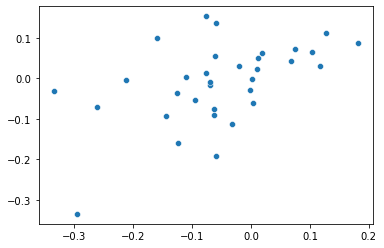

In [87]:
sns.scatterplot(x=grouped_ac_test[100], y=grouped_ac_test_copy[98])

In [88]:
grouped_ac_test[100].sum()

-1.78993

In [89]:
grouped_ac_test_copy[100].sum()

0.50320953

In [90]:
MolDrawer().plot_values_for_mol(mol=copy_test, values=grouped_ac_test_copy[100], suffix=f'change_torsion', save_dir='atomic_contributions_diff')

In [91]:
diff = grouped_ac_test_copy[100] - grouped_ac_test[100]

In [92]:
MolDrawer().plot_values_for_mol(mol=copy_test, values=diff, suffix=f'change_torsion_diff', save_dir='atomic_contributions_diff')

In [93]:
from ConfScorer import ConfScorer, ConfAnalyzer

In [98]:
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
copy_train = copy.deepcopy(train_mol)

In [99]:
GetDihedralDeg(copy_train.GetConformer(100), 26, 18, 19, 20)

178.75587024618162

In [100]:
SetDihedralDeg(copy_train.GetConformer(100), 26, 18, 19, 20, 60)

In [101]:
mcv.view(copy_train)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [102]:
data_list = mol_featurizer.featurize_mol(copy_train)
batch = Batch.from_data_list(data_list)

In [103]:
preds.argsort()

tensor([100,  98,  40,  18,   9,  55,  63,  89,  31,  49,  65,   8,  96,  27,
          6,  30,  45,   2,  94,  28,  86,  70,  35,  56,  99,  60,  36,  90,
         46,  15,  48,  17,  69,  10,  32,  51,  53,  85,  34,  59,  66,  68,
         41,  44,   1,  62,  87,  23,  97,  71,  93,  74,  81,  39,  26,  29,
         33,  43,  42,  82,  91,  64,  20,  67,  58,  75,  25,   3,  13,   7,
         78,  77,  50,  61,  92,  83,  73,  54,  72,  12,  16,   0,  37,  47,
         84,   5,  95,   4,  22,  76,  88,  57,  21,  80,  24,  14,  79,  52,
         38,  11,  19])

In [105]:
ac_test = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac_train_copy = ac_test.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [106]:
grouped_ac_train_copy

array([[ 0.07433904,  0.12993392,  0.06153179, ..., -0.00517297,
         0.16664678, -0.01717678],
       [ 0.0379436 ,  0.07940139,  0.0707071 , ...,  0.05308912,
         0.06314   ,  0.0226273 ],
       [ 0.08711701,  0.09818675, -0.01855092, ...,  0.03803772,
         0.0846818 ,  0.05205522],
       ...,
       [-0.00444431,  0.16576621, -0.07509728, ...,  0.04765751,
         0.02590478,  0.02830691],
       [ 0.0657385 ,  0.10854727,  0.07029013, ...,  0.03635326,
        -0.04483574,  0.00297023],
       [-0.06256474,  0.02588436, -0.05758741, ...,  0.09957726,
         0.0825071 ,  0.09680957]], dtype=float32)

<AxesSubplot:>

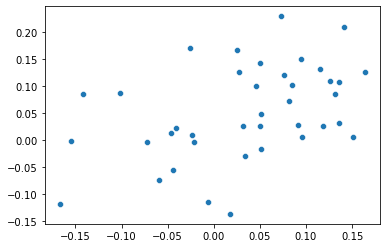

In [107]:
sns.scatterplot(x=grouped_ac_train[100], y=grouped_ac_train_copy[98])

In [108]:
grouped_ac_train[100].sum()

1.2933302

In [110]:
grouped_ac_train_copy[100].sum()

1.8007643

In [111]:
MolDrawer().plot_values_for_mol(mol=copy_train, values=grouped_ac_train_copy[100], suffix=f'change_torsion_train', save_dir='atomic_contributions_diff')

In [112]:
diff = grouped_ac_train_copy[100] - grouped_ac_train[100]

In [113]:
MolDrawer().plot_values_for_mol(mol=copy_test, values=diff, suffix=f'change_torsion_diff_train', save_dir='atomic_contributions_diff')

In [ ]:
26, 18, 19, 20

In [89]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [90]:
diff = grouped_ac[34] - grouped_ac[100]

In [93]:
MolDrawer().plot_values_for_mol(mol=train_mol, values=diff, suffix='diff_34_100_trian', save_dir='atomic_contributions_diff')

In [55]:
batch_i = 0
pred_is = atomic_contributions[batch.batch == batch_i]
pred_is = pred_is.numpy()

In [62]:
float(pred_is[i][0])

-0.01201905868947506

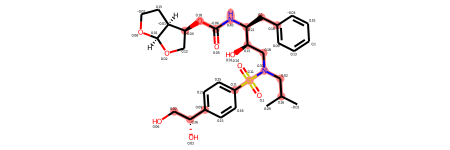

In [79]:
copy_mol = copy.deepcopy(test_mol)
Chem.rdDepictor.Compute2DCoords(copy_mol)
for i, at in enumerate(copy_mol.GetAtoms()) :
    value = str(round(float(pred_is[i][0]), 2))
    at.SetProp('atomNote', value)
copy_mol

In [81]:
save_2d_depiction(copy_mol, 'generated_ranking_results/test_mol.png')

In [42]:
bioactive_mol = copy.deepcopy(test_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(test_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(test_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [43]:
preds.argsort()

array([100,   3,  18,  63,  77,  94,  47,  38,  54,  57,  30,  60,  14,
        78,  46,  91,  86,  92,  37,  28,  16,  59,  89,  71,  23,  62,
         7,  95,  65,  67,  70,   9,  50,  84,  48,  96,  44,  34,  33,
        11,   1,  24,  53,  10,  90,  81,  45,  17,  85,  41,  69,  22,
        87,  27,  26,  49,  58,  97,  42,  79,  29,  12,  82,  80,  76,
        75,   5,  40,  55,  99,  52,  15,  72,   4,  88,  39,   8,  36,
        66,  74,  31,   2,   0,  20,  35,   6,  51,  73,  93,  43,  83,
        19,  25,  13,  68,  64,  98,  32,  21,  61,  56])

In [1]:
import importlib
import ConfScorer
importlib.reload(ConfScorer)
ca = ConfScorer.ConfAnalyzer()

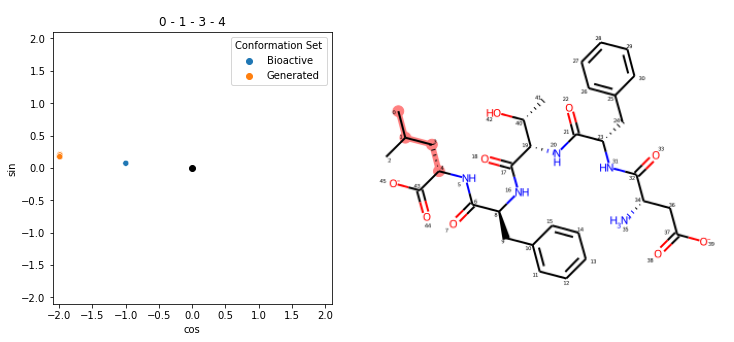

<Figure size 432x288 with 0 Axes>

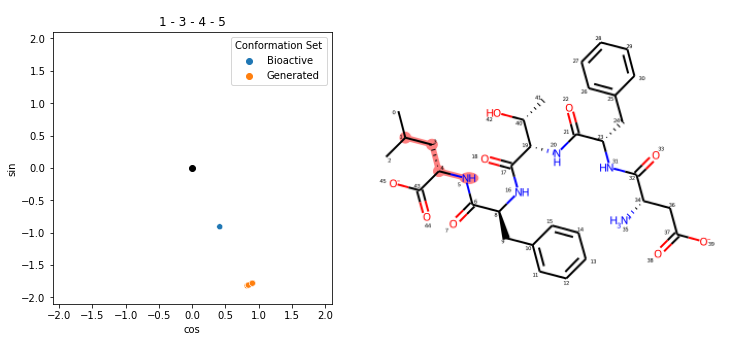

<Figure size 432x288 with 0 Axes>

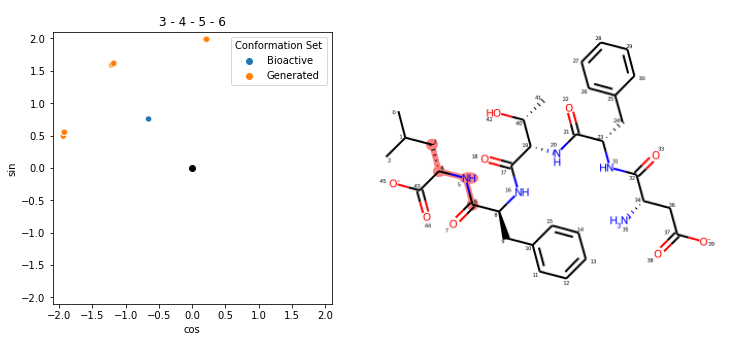

<Figure size 432x288 with 0 Axes>

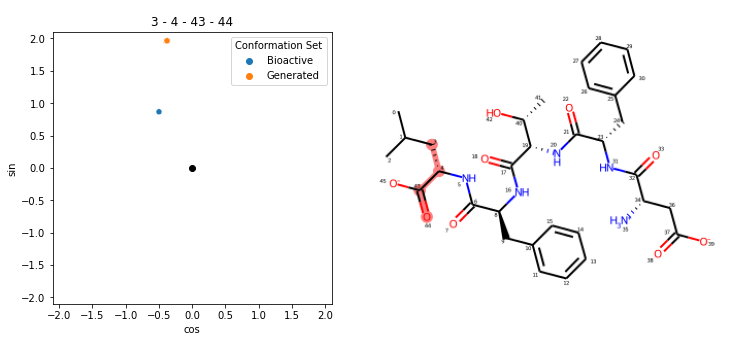

<Figure size 432x288 with 0 Axes>

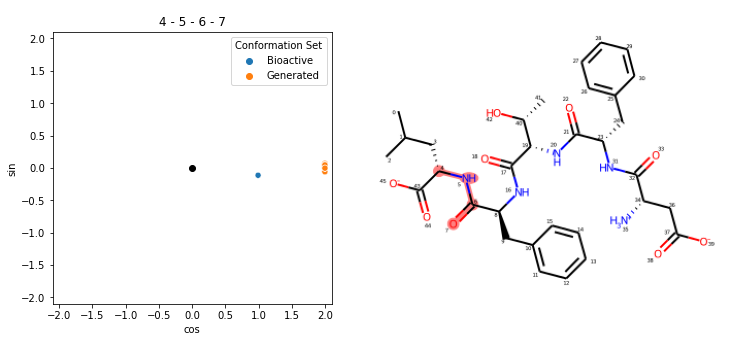

<Figure size 432x288 with 0 Axes>

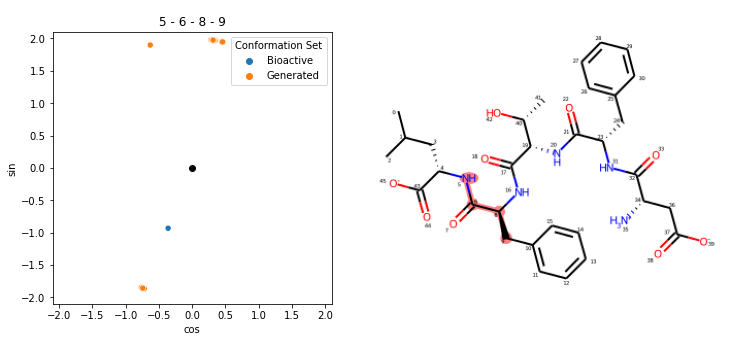

<Figure size 432x288 with 0 Axes>

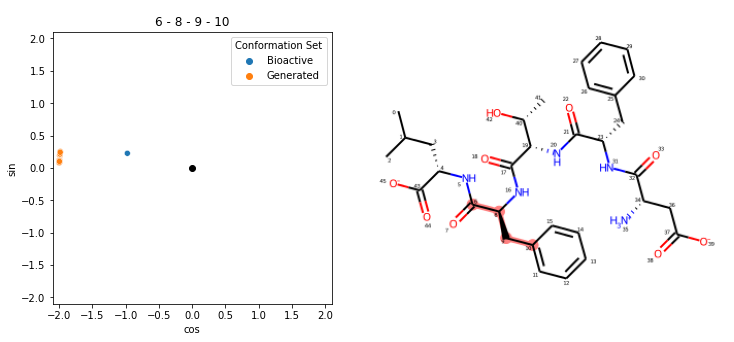

<Figure size 432x288 with 0 Axes>

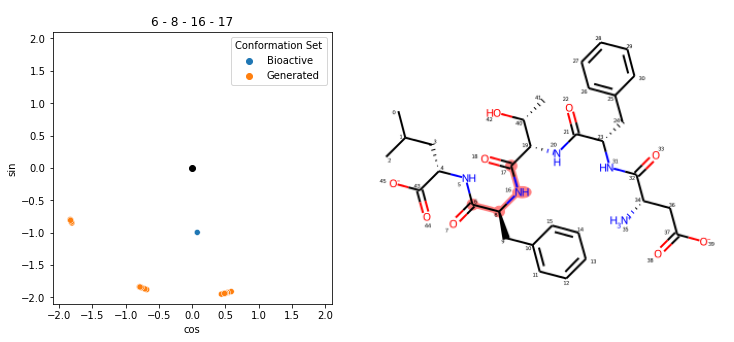

<Figure size 432x288 with 0 Axes>

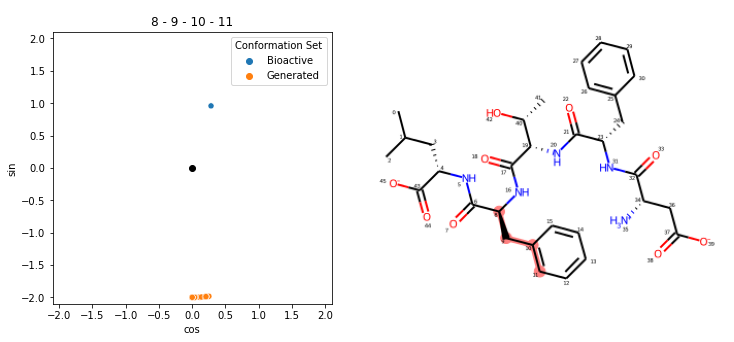

<Figure size 432x288 with 0 Axes>

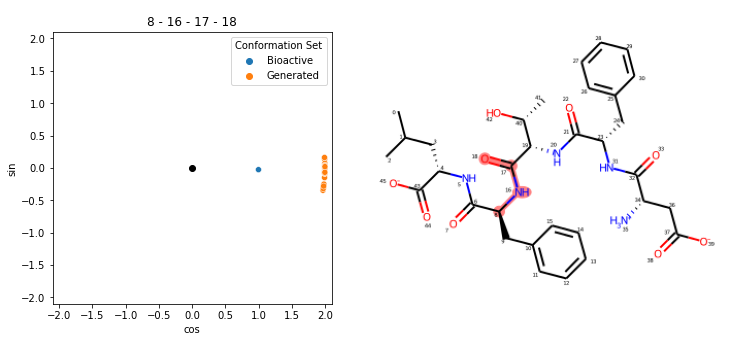

<Figure size 432x288 with 0 Axes>

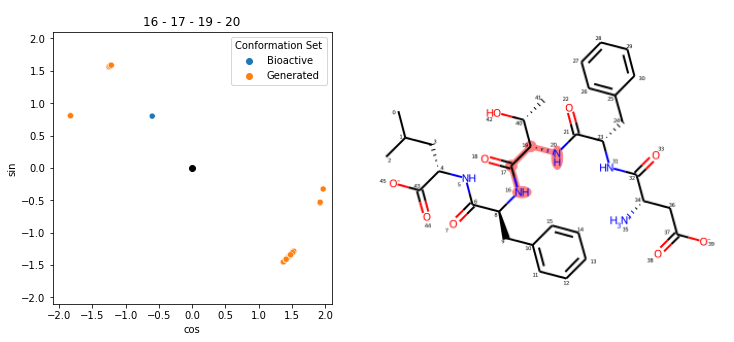

<Figure size 432x288 with 0 Axes>

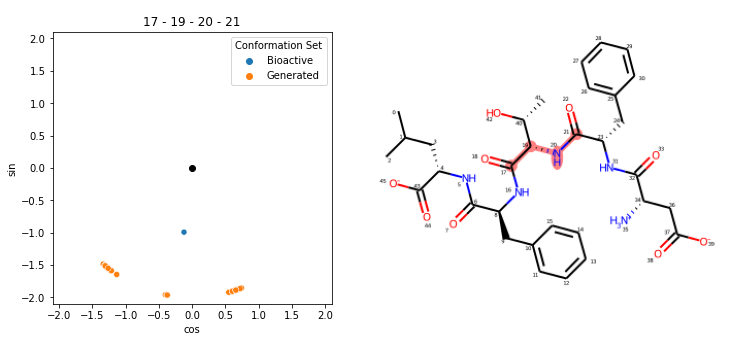

<Figure size 432x288 with 0 Axes>

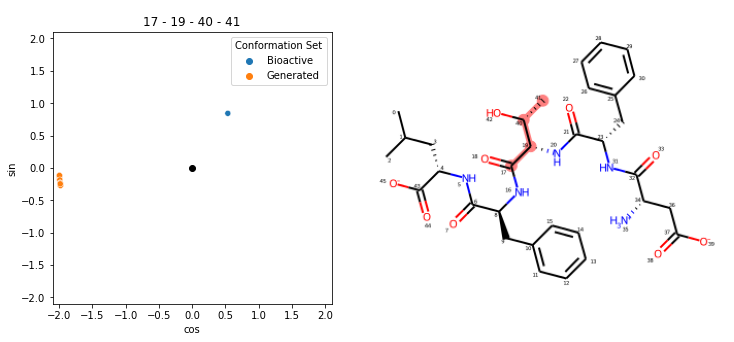

<Figure size 432x288 with 0 Axes>

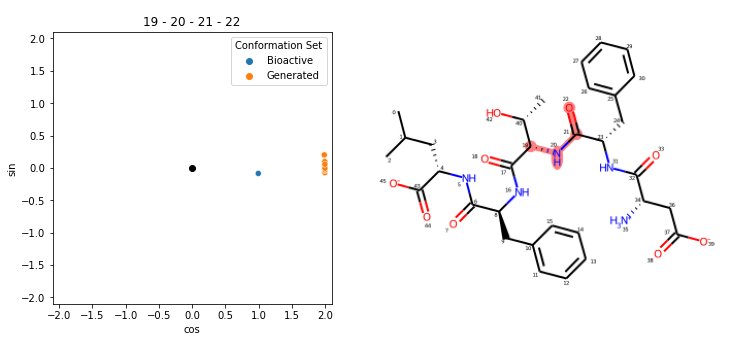

<Figure size 432x288 with 0 Axes>

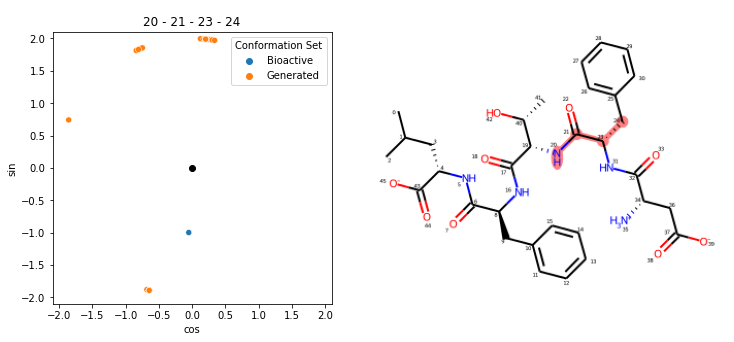

<Figure size 432x288 with 0 Axes>

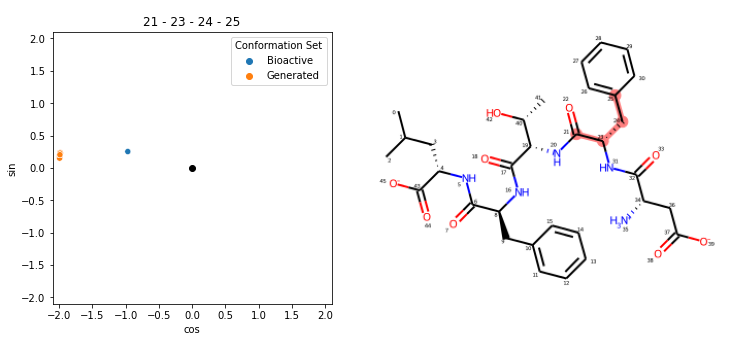

<Figure size 432x288 with 0 Axes>

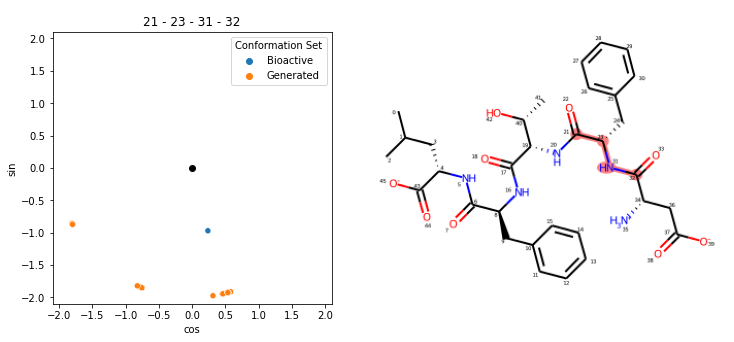

<Figure size 432x288 with 0 Axes>

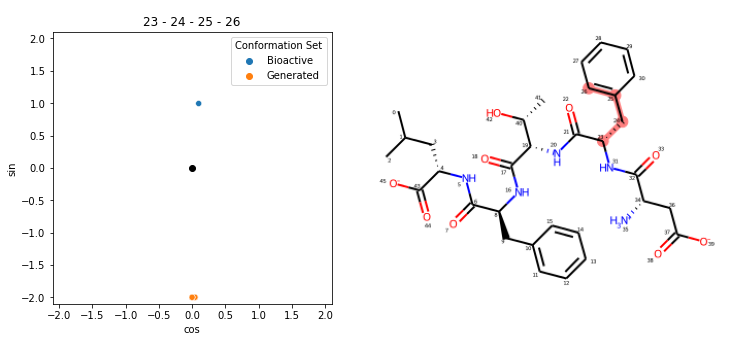

<Figure size 432x288 with 0 Axes>

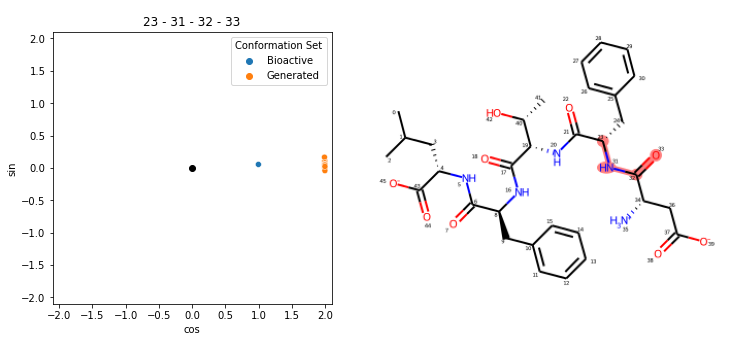

<Figure size 432x288 with 0 Axes>

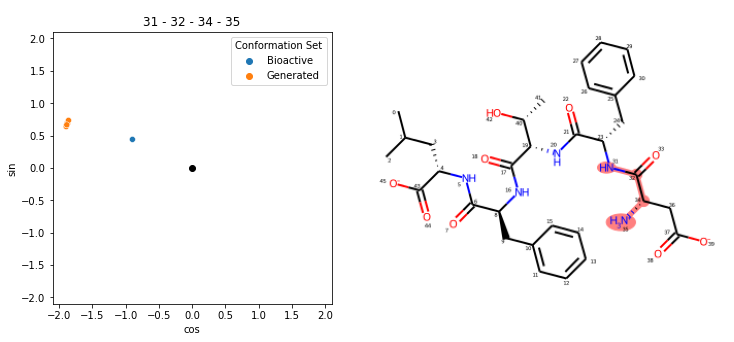

<Figure size 432x288 with 0 Axes>

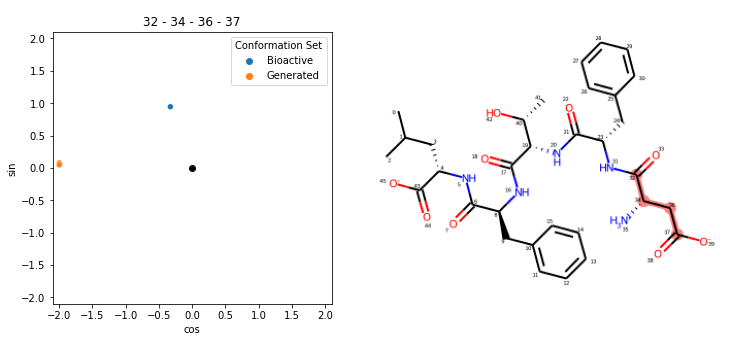

<Figure size 432x288 with 0 Axes>

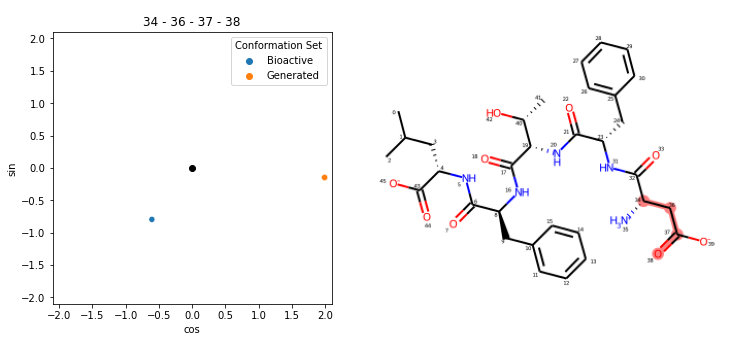

<Figure size 432x288 with 0 Axes>

In [45]:
dihedrals_atom_ids = ca.get_rotatable_bonds_atom_idx(generated_mol)
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, mol_dict=mol_dict)

In [ ]:
grouped_ac.min(axis=0)

In [ ]:
rot_bonds = ca.get_rotatable_bonds_atom_idx(test_mol)

In [ ]:
cosins = np.empty((0, generated_mol.GetNumConformers()))
for dihedral_indexes in rot_bonds :
    dihedrals = ca.get_conformers_dihedrals_deg(generated_mol, *dihedral_indexes)
    dihedrals_rad = np.deg2rad(dihedrals)
    coss = np.cos(dihedrals_rad)
    sins = np.sin(dihedrals_rad)
    cosins = np.vstack([cosins, coss, sins])

In [ ]:
data_list = mf.featurize_mol(generated_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(generated_mol.GetNumConformers(), generated_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [ ]:
cosins = cosins.transpose()

In [ ]:
cosins.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(cosins, preds)

In [ ]:
lr.coef_.max()

In [ ]:
lr.coef_.argsort()

In [ ]:
lr.coef_.min()

In [ ]:
rot_bonds

In [ ]:
rot_bonds[21]

In [ ]:
plt.plot(lr.coef_)

In [ ]:
lr_preds = lr.predict(cosins)

In [ ]:
plt.plot(lr_preds - preds)

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
plt.figure(figsize=(10,10))
sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=preds.reshape(-1).detach().numpy())
plt.show()

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(27, 28, 29, 30), (33, 27, 28, 29), (36, 22, 23, 24)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [ ]:
bioactive_mol = copy.deepcopy(train_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(train_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(train_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [ ]:
dihedrals = ca.get_conformers_dihedrals_deg(train_mol, 3, 4, 5, 43)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals, y=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(3, 4, 5, 43)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
targets = mf.get_bioactive_rmsds(train_mol)
preds = model(batch)

In [ ]:
x = targets.detach().numpy()
y = preds.reshape(-1).detach().numpy()
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 6.2)
plt.ylim(-0.2, 6.2)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression_train.png', dpi=300)

In [ ]:
sdwriter = Chem.SDWriter('test_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

In [ ]:
sdwriter = Chem.SDWriter('train_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

# Largest regression RMSE

In [ ]:
rmses = []
for smiles, results in conf_results.items() :
    rmses.extend(results['rmse'])

In [ ]:
max_rmse_idx = np.argmax(rmses)

In [ ]:
max_rmse = rmses[max_rmse_idx]
max_rmse

In [ ]:
for smiles, results in conf_results.items() :
    if max_rmse in results['rmse'] :
        print(smiles)
        break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
mean_rmses = []
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        mean_rmses.append(mean_rmse)

In [ ]:
max_rmse_idx = np.argmax(mean_rmses)

In [ ]:
max_rmse = mean_rmses[max_rmse_idx]

In [ ]:
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        if max_rmse == mean_rmse :
            print(smiles)
            break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
test_fp = AllChem.GetMorganFingerprint(ce.mol, 3, useChirality=True)
sims = []
for train_fp in train_fps :
    dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
    sims.append(dice_sim)
max_sim = max(sims)
max_sim_idx = np.argmax(sims)
sim_smiles = train_smiles[max_sim_idx]

sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
pdb_id = sim_ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mf = MoleculeFeaturizer()
model = get_model()
model.eval()
data_list = mf.featurize_mol(sim_ce.mol)
targets = mf.get_bioactive_rmsds(sim_ce.mol).numpy()

batch = Batch.from_data_list(data_list)
preds = model(batch).detach().numpy().squeeze()
errors = np.abs(targets - preds)

properties = {'RMSE' : errors,
              'ARMSD' : targets,
              'Predicted ARMSD' : preds,
              'UFF Energy' : batch.energy.numpy()}
mcv.view(sim_ce.mol,
         properties=properties)

In [ ]:
new_mol = copy.deepcopy(sim_ce.mol)

In [ ]:
d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(new_mol)
d2d.FinishDrawing()
d2d.WriteDrawingText('mol.png') 

In [ ]:
AlignMolConformers(new_mol, atomIds=list(range(2, 34)))

In [ ]:
mcv.view(new_mol,
         properties=properties)

In [ ]:
batch

In [ ]:
mcs = rdFMCS.FindMCS([ce.mol, sim_ce.mol])

In [ ]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(core)

In [ ]:
mol_copy = copy.deepcopy(ce.mol)
mol_copy.RemoveAllConformers()
mol_with_atom_index(mol_copy)

In [ ]:
core = Chem.MolFromSmarts(mcs.smarts)
mol1_atoms = ce.mol.GetSubstructMatches(core)[0]
mol2_atoms = sim_ce.mol.GetSubstructMatches(core)[0]
atom_map = list(zip(mol1_atoms, mol2_atoms))

In [ ]:
for i in range(ce.mol.GetNumConformers()) :
    AlignMol(ce.mol, sim_ce.mol, i, 3, atomMap=atom_map)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
mcv.view(ce.mol, properties)
mcv.view(sim_ce.mol)